In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import animation
from mpl_toolkits.basemap import Basemap
import contextily as cx  
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial import cKDTree
from datetime import datetime
from matplotlib import gridspec
import scipy.stats as stats
import wavespectra
import netCDF4 as nc
import h5py
import numbers
import copy
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import pymannkendall as mk
import calendar
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
import re
from scipy.stats import norm

In [2]:
area = [65, -12, 48, 10] # DCSM area in the North Sea (degrees): North, West, South, East
year_start = 2023
year_end = 2023

## Extract HurryWave Data

In [3]:
import glob

def read_stations_from_obs(file_path):
    """
    Reads station coordinates and names from a .obs file.

    Returns:
        xs (list[float]): x coordinates
        ys (list[float]): y coordinates
        names (list[str]): station names
    """
    xs, ys, names = [], [], []
    with open(file_path, 'r') as f:
        for line in f:
            if '#' in line:
                parts = line.strip().split()
                x = float(parts[0])
                y = float(parts[1])
                name = " ".join(parts[3:])  # everything after "#"
                xs.append(x)
                ys.append(y)
                names.append(name)
    return xs, ys, names


def get_tspinup_from_inp(run_path):
    inp = os.path.join(run_path, "hurrywave.inp")
    tspinup = 0
    if os.path.exists(inp):
        with open(inp, "r") as f:
            for line in f:
                if line.strip().startswith("tspinup"):
                    try:
                        tspinup = int(line.split("=")[1].strip())
                    except Exception:
                        tspinup = 0
                    break
    return tspinup

def his_remove_spinup(year, model_base_path, his):
    # Find the start and stop times from the input file
    inp_file = os.path.join(model_base_path, str(year), 'hurrywave.inp')
    with open(inp_file, 'r') as f:
        for line in f:
            if line.strip().startswith('tspinup'):
                tspinup = line.split('=')[1].strip()

    tspinup_sec = int(tspinup)
    his_time_vals = his["time"].values
    spinup_end_time = his_time_vals[0] + np.timedelta64(tspinup_sec, 's')
    his_spinup_mask = his_time_vals >= spinup_end_time
    his = his.sel(time=his_spinup_mask)
    return his

def extract_runs_hurrywave_data(runs_base_dir, run_ids=None, verbose=True):
    """
    Extract hurrywave station time series for multiple runs.
    Returns: data_per_run: dict[run_name][station_name][variable] = np.ndarray (and 'time')
    """
    runs = run_ids if run_ids is not None else sorted(
        [d for d in os.listdir(runs_base_dir) if os.path.isdir(os.path.join(runs_base_dir, d))]
    )
    data_per_run = {}
    for run in sorted(runs):
        run_path = os.path.join(runs_base_dir, run)
        if not os.path.isdir(run_path):
            if verbose:
                print(f"Skipping non-dir {run_path}")
            continue

        # find his file (allow nested)
        his_candidates = glob.glob(os.path.join(run_path, "**", "hurrywave_his.nc"), recursive=True)
        if not his_candidates:
            if verbose:
                print(f"No hurrywave_his.nc found in {run_path}, skipping")
            continue
        his_file = his_candidates[0]

        obs_candidates = glob.glob(os.path.join(run_path, "**", "hurrywave.obs"), recursive=True)
        obs_file = obs_candidates[0] if obs_candidates else None

        # read obs coords (if available) for station_x/y
        xs, ys, obs_station_names = ([], [], [])
        if obs_file:
            try:
                xs, ys, obs_station_names = read_stations_from_obs(obs_file)
            except Exception:
                xs, ys, obs_station_names = [], [], []

        # open his dataset
        ds = xr.open_dataset(his_file)

        # remove spinup using tspinup from inp in run directory
        tspinup_sec = get_tspinup_from_inp(run_path)

        print(f"Run {run}: applying tspinup of {tspinup_sec} seconds")

        try:
            time_vals = ds["time"].values
            if time_vals.size > 0 and tspinup_sec > 0:
                spinup_end = time_vals[0] + np.timedelta64(int(tspinup_sec), "s")
                ds = ds.sel(time=slice(spinup_end, None))
        except Exception:
            pass

        # station names in his file (fall back to obs names)
        try:
            station_names = ds["station_name"].astype(str).values
        except Exception:
            station_names = np.array(obs_station_names, dtype=str)

        # select point variables with dims (time, stations)
        data_vars = [v for v in ds.data_vars if ds[v].dims == ("time", "stations")]
        time = ds["time"].values

        # --- remove the last time step globally (once per run) ---
        if time.size > 1:
            time = time[:-1]

        data_per_run[run] = {}
        for i, st in enumerate(obs_station_names):
            st_name = st.strip()
            data_per_run[run].setdefault(st_name, {})
            data_per_run[run][st_name]["time"] = time

            # attach station coords if available
            if obs_station_names and st_name in obs_station_names:
                idx = obs_station_names.index(st_name)
                data_per_run[run][st_name]["station_x"] = xs[idx]
                data_per_run[run][st_name]["station_y"] = ys[idx]

            # copy variables, trimming last time-step
            for v in data_vars:
                try:
                    arr = ds[v].isel(stations=i).values
                except Exception:
                    try:
                        arr = ds[v][:, i].values
                    except Exception:
                        arr = np.array([])
                if st == "North Cormorant":
                    print("Array0 ==> for North Cormorant, var", v)
                    print(arr[0])
                if isinstance(arr, np.ndarray) and arr.size > 1:
                    arr = arr[:-1]
                data_per_run[run][st_name][v] = arr

            # keep depth if present as scalar per station, otherwise trim it to match other variables
            if "point_depth" in ds:
                try:
                    depth = ds["point_depth"].isel(stations=i).values
                    if np.isscalar(depth):
                        data_per_run[run][st_name]["point_depth"] = np.array([depth]).astype(float)
                    else:
                        data_per_run[run][st_name]["point_depth"] = depth[:-1] if depth.size > 1 else depth
                except Exception:
                    pass

        ds.close()
        if verbose:
            print(f"Loaded run {run}: {len(data_per_run[run].keys())} stations, {len(data_vars)} variables")

    return data_per_run, obs_station_names




In [4]:
runs = [f"{i:04d}" for i in range(0, 12)]  # "0000" .. "0011"

runs_base_july = "/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/04_modelruns/SENSITIVITY/07July2023"
runs_base_december = "/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/04_modelruns/SENSITIVITY/12December2023"

data_per_run_july, station_names = extract_runs_hurrywave_data(runs_base_july, run_ids=runs)
data_per_run_december, station_names = extract_runs_hurrywave_data(runs_base_december, run_ids=runs)

Run 0000: applying tspinup of 2678400 seconds
Array0 ==> for North Cormorant, var point_hm0
0.6402351
Array0 ==> for North Cormorant, var point_tp
5.674586
Array0 ==> for North Cormorant, var point_wavdir
220.1464
Array0 ==> for North Cormorant, var point_dirspr
47.52908
Array0 ==> for North Cormorant, var point_depth
168.64322
Array0 ==> for North Cormorant, var wind_speed
3.7828443
Array0 ==> for North Cormorant, var wind_direction
141.24556
Loaded run 0000: 8 stations, 7 variables
Run 0001: applying tspinup of 2678400 seconds
Array0 ==> for North Cormorant, var point_hm0
0.63891613
Array0 ==> for North Cormorant, var point_tp
5.6767797
Array0 ==> for North Cormorant, var point_wavdir
220.73486
Array0 ==> for North Cormorant, var point_dirspr
47.39193
Array0 ==> for North Cormorant, var point_depth
168.64322
Array0 ==> for North Cormorant, var wind_speed
3.7828443
Array0 ==> for North Cormorant, var wind_direction
141.24556
Loaded run 0001: 8 stations, 7 variables
Run 0002: applying 

In [5]:
# Determine model variable names from one example
example_run = '0003'
example_station = 'Euro platform'
model_var_names = list(data_per_run_july[example_run][example_station].keys())
for k in ['time', 'station_x', 'station_y']:
    if k in model_var_names:
        model_var_names.remove(k)


def remove_concatenation_outliers(time_array, *data_arrays):
    """
    Remove entries where two consecutive times are both midnight (00:00:00).
    If this occurs, remove the entry of the first midnight only.

    Args:
        time_array (np.ndarray or pd.Series): Array of datetime64 or pandas Timestamps.
        *data_arrays: Any number of arrays (same length as time_array) to filter in sync.

    Returns:
        filtered_time, filtered_data_arrays...
    """
    time_pd = pd.to_datetime(time_array)

    if len(time_pd) == 0:
        return (time_array,) + tuple(data_arrays)

    # Extract hour/minute/second safely for both Series and DatetimeIndex
    if isinstance(time_pd, pd.Series):
        hours = time_pd.dt.hour
        minutes = time_pd.dt.minute
        seconds = time_pd.dt.second
    else:
        hours = time_pd.hour
        minutes = time_pd.minute
        seconds = time_pd.second

    # Identify midnight timestamps
    is_midnight = (hours == 0) & (minutes == 0) & (seconds == 0)

    # Find consecutive midnights (00:00 → 00:00)
    remove_idx = np.where(is_midnight[:-1] & is_midnight[1:])[0]

    # Build mask
    mask = np.ones(len(time_pd), dtype=bool)
    mask[remove_idx] = False

    filtered_time = np.asarray(time_array)[mask]

    filtered_data_arrays = []
    for arr in data_arrays:
        a = np.asarray(arr)
        # Only apply mask if it matches time dimension
        if a.ndim == 1 and len(a) == len(time_array):
            filtered_data_arrays.append(a[mask].copy())
        else:
            filtered_data_arrays.append(a.copy() if hasattr(a, "copy") else a)

    return (filtered_time, *filtered_data_arrays)


def clean_data_per_run(data_per_run, station_names, model_var_names):
    """
    Clean each run and station in place — removing concatenation outliers.
    Modifies the input dict directly.
    """
    for run, data_per_station in data_per_run.items():
        for station in station_names:
            if station not in data_per_station:
                continue

            station_data = data_per_station[station]
            time = station_data.get('time', np.array([]))
            vars_present = [v for v in model_var_names if v in station_data]

            if len(time) == 0 or not vars_present:
                continue

            data_arrays = [station_data[v] for v in vars_present]
            filtered_results = remove_concatenation_outliers(time, *data_arrays)

            if len(filtered_results) == len(data_arrays) + 1:
                filtered_time = filtered_results[0]
                filtered_data_arrays = filtered_results[1:]
                # ✅ Modify in place (same variable names)
                station_data['time'] = filtered_time
                for var, arr in zip(vars_present, filtered_data_arrays):
                    station_data[var] = arr
            else:
                print(f"⚠️ Warning: No valid data arrays returned for {station} in run {run}.")


# ✅ Apply cleaning IN PLACE — no renaming needed
clean_data_per_run(data_per_run_july, station_names, model_var_names)
clean_data_per_run(data_per_run_december, station_names, model_var_names)

In [6]:
# Path to Waterinfo_RWS data
waterinfo_base = '/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/Waterinfo_RWS'

# Collect all years available in Waterinfo_RWS
obs_years = sorted([d for d in os.listdir(waterinfo_base) if d.isdigit()])
# Only keep years from year_start down to year_end (inclusive)
obs_years = [year for year in obs_years if int(year) <= year_start and int(year) >= year_end]
obs_years = sorted(obs_years, reverse=True)  # Descending order: year_start to year_end

print(obs_years)
# Dictionary to hold all observational data per station
obs_data_per_station = {}

for year in obs_years:
    print(f"Loading observational data for year: {year}")
    year_dir = os.path.join(waterinfo_base, year)
    for fname in os.listdir(year_dir):
        if fname.endswith('.csv'):
            station = fname.replace('.csv', '')
            fpath = os.path.join(year_dir, fname)
            if not os.path.exists(fpath):
                print(f"File not found: {fpath}, skipping.")
                continue

            # Check if file is empty or contains no columns
            with open(fpath, 'r') as checkfile:
                first_line = checkfile.readline()
                if not first_line or len(first_line.strip().split(',')) < 2:
                    print(f"File {fpath} contains no columns, skipping.")
                    continue
            df = pd.read_csv(fpath, parse_dates=True)
            if df.empty:
                print(f"Skipping {fpath} as it contains no data records.")
                continue  # Skip file if no data record
            if df.empty or len(df) < 10:
                print(f"Skipping {fpath} as it contains no data records or less than 10 records.")
                continue  # Skip file if no data record or too few records
            df['year'] = int(year)
            if station not in obs_data_per_station:
                obs_data_per_station[station] = [df]
            else:
                obs_data_per_station[station].append(df)

    print(f"Finished loading observational data from Waterinfo_RWS for {len(obs_data_per_station)} stations.")

# Concatenate yearly dataframes for each station
for station in obs_data_per_station:
    obs_data_per_station[station] = pd.concat(obs_data_per_station[station], ignore_index=True)
    #divide all values of hm0 by 100 as they are in cm
    if 'hm0' in obs_data_per_station[station]:
        obs_data_per_station[station]['hm0'] = obs_data_per_station[station]['hm0'] / 100

    # t13 is divided by 0.95 to move to Tp
    if 't13' in obs_data_per_station[station]:
        obs_data_per_station[station]['t13'] = obs_data_per_station[station]['t13'] / 0.95

    # If the dataframe has
    # 'Unnamed: 0' as a column, rename it to 'time'
    for station in obs_data_per_station:
        if isinstance(obs_data_per_station[station], pd.DataFrame):
            if 'Unnamed: 0' in obs_data_per_station[station]:
                # Convert to pandas datetime first, then to numpy.datetime64 array
                print(station)
                time_pd = pd.to_datetime(obs_data_per_station[station].pop('Unnamed: 0'))
                obs_data_per_station[station]['time'] = time_pd.values.astype('datetime64[ns]')




['2023']
Loading observational data for year: 2023
Skipping /gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/Waterinfo_RWS/2023/Platform Hoorn Q1-A.csv as it contains no data records or less than 10 records.
Skipping /gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/Waterinfo_RWS/2023/Platform F16-A.csv as it contains no data records or less than 10 records.
Finished loading observational data from Waterinfo_RWS for 6 stations.
IJmuiden munitiestortplaats
Platform D15-A
K13a platform
K13 Alpha
North Cormorant


/scratch-local/72649/ipykernel_674593/2251067716.py:64: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  time_pd = pd.to_datetime(obs_data_per_station[station].pop('Unnamed: 0'))
/scratch-local/72649/ipykernel_674593/2251067716.py:65: UserWarning: no explicit representation of timezones available for np.datetime64
  obs_data_per_station[station]['time'] = time_pd.values.astype('datetime64[ns]')


Euro platform


In [7]:
obs_data_per_station_july = {}
obs_data_per_station_december = {}

def _get_run_time_range(data_per_run, station):
    mins, maxs = [], []
    for run, runs_dict in data_per_run.items():
        st = runs_dict.get(station)
        if st is None:
            continue
        t = st.get("time")
        if t is None or len(t) == 0:
            continue
        tarr = np.asarray(t).astype("datetime64[ns]")
        mins.append(tarr.min())
        maxs.append(tarr.max())
    if not mins:
        return None, None
    return np.min(mins), np.max(maxs)

for station, obs_df in obs_data_per_station.items():
    if not isinstance(obs_df, pd.DataFrame) or "time" not in obs_df:
        continue

    df = obs_df.copy()
    # ensure consistent dtype for comparisons
    df['time'] = pd.to_datetime(df['time']).values.astype("datetime64[ns]")

    j_min, j_max = _get_run_time_range(data_per_run_july, station)
    if j_min is not None:
        mask_j = (df['time'].values >= np.datetime64(j_min)) & (df['time'].values <= np.datetime64(j_max))
        obs_data_per_station_july[station] = df.loc[mask_j].reset_index(drop=True)
    else:
        obs_data_per_station_july[station] = df.reset_index(drop=True)

    # Uncomment and adapt for December if needed:
    d_min, d_max = _get_run_time_range(data_per_run_december, station)
    if d_min is not None:
        mask_d = (df['time'].values >= np.datetime64(d_min)) & (df['time'].values <= np.datetime64(d_max))
        obs_data_per_station_december[station] = df.loc[mask_d].reset_index(drop=True)
    else:
        obs_data_per_station_december[station] = df.reset_index(drop=True)


In [8]:
def synchronize_station_keys(model_dict, meas_dict):
    # 1. Merge "K13a platform" into "K13 Alpha" in meas_dict
    k13a_key = None
    for key in meas_dict.keys():
        if "k13a" in key.lower():
            k13a_key = key
            break

    if k13a_key is not None:
        target_key = "K13 Alpha"
        k13a_data = meas_dict.get(k13a_key)
        target_data = meas_dict.get(target_key)

        if isinstance(k13a_data, pd.DataFrame) and isinstance(target_data, pd.DataFrame):
            merged = pd.concat([k13a_data, target_data]).drop_duplicates()
        else:
            merged = target_data if target_data is not None else k13a_data

        meas_dict[target_key] = merged

        if k13a_key != target_key:
            del meas_dict[k13a_key]

    # 2. Determine reference columns from meas_dict (use first DataFrame found)
    ref_columns = None
    for data in meas_dict.values():
        if isinstance(data, pd.DataFrame):
            ref_columns = data.columns
            break

    if ref_columns is None:
        raise ValueError("No DataFrame found in meas_dict to use as reference for columns.")

    # 3. Add missing stations from model_dict into meas_dict with empty DataFrame
    for station in model_dict.keys():
        if station not in meas_dict:
            meas_dict[station] = pd.DataFrame(columns=ref_columns)

    # 4. Ensure all existing DataFrames have the same columns
    for station, data in meas_dict.items():
        if isinstance(data, pd.DataFrame):
            for col in ref_columns:
                if col not in data.columns:
                    data[col] = np.nan
            meas_dict[station] = data[ref_columns]  # reorder

    return model_dict, meas_dict

for run in data_per_run_july:
    data_per_run_july[run], obs_data_per_station_july = synchronize_station_keys(data_per_run_july[run], obs_data_per_station_july)

for run in data_per_run_december:
    data_per_run_december[run], obs_data_per_station_december = synchronize_station_keys(data_per_run_december[run], obs_data_per_station_december)

for station, df in obs_data_per_station_july.items():
    if isinstance(df, pd.DataFrame) and df["time"].shape[0] > 2:
        obs_data_per_station_july[station] = df[df['time'].dt.minute == 0].reset_index(drop=True)

for station, df in obs_data_per_station_december.items():
    if isinstance(df, pd.DataFrame) and df["time"].shape[0] > 2:
        obs_data_per_station_december[station] = df[df['time'].dt.minute == 0].reset_index(drop=True)




In [9]:
print(data_per_run_july['0000'].keys())
print(data_per_run_december['0000'].keys())
print(obs_data_per_station_july.keys())
print(obs_data_per_station_december.keys())

dict_keys(['Euro platform', 'Platform D15-A', 'Platform Hoorn Q1-A', 'North Cormorant', 'K13 Alpha', 'Platform F16-A', 'IJmuiden munitiestortplaats', 'A12 platform'])
dict_keys(['Euro platform', 'Platform D15-A', 'Platform Hoorn Q1-A', 'North Cormorant', 'K13 Alpha', 'Platform F16-A', 'IJmuiden munitiestortplaats', 'A12 platform'])
dict_keys(['IJmuiden munitiestortplaats', 'Platform D15-A', 'K13 Alpha', 'North Cormorant', 'Euro platform', 'Platform Hoorn Q1-A', 'Platform F16-A', 'A12 platform'])
dict_keys(['IJmuiden munitiestortplaats', 'Platform D15-A', 'K13 Alpha', 'North Cormorant', 'Euro platform', 'Platform Hoorn Q1-A', 'Platform F16-A', 'A12 platform'])


In [10]:
def filter_obs_t13(obs_data_per_station, station_names):
    for station in station_names:
        df = obs_data_per_station.get(station)
        if df is not None and not df.empty and 't13' in df and 'tmax' in df:
            mask = (df['t13'] < df['tmax']) | df['t13'].isna() | df['tmax'].isna()
            obs_data_per_station[station] = df.loc[mask].reset_index(drop=True)




def remove_outliers(data_dict, varnames, threshold):
    """
    Remove all entries where the target variable exceeds the threshold.
    Works for both dict-of-DataFrame (obs) and dict-of-dicts (model).

    Args:
        data_dict (dict): Dictionary of station datasets.
        varnames (list of str): Possible keys for the variable (e.g. ["hm0", "point_hm0"]).
        threshold (float): Threshold value.
    """
    for station, dset in data_dict.items():
        # --- Case 1: whole dataset is a DataFrame ---
        if isinstance(dset, pd.DataFrame):
            for v in varnames:
                if v in dset:
                    # Only mask values where NOT NaN and > threshold; keep NaNs
                    if dset[v].empty:
                        print(f"Skipping {station} as {v} is empty.")
                        continue
                    size_before = len(dset)
                    mask = (dset[v].isna()) | (dset[v] <= threshold)
                    data_dict[station] = dset.loc[mask].copy()
                    size_after = len(data_dict[station])
                    print(f"{station}: {v} - size before: {size_before}, size after: {size_after}, outliers removed: {size_before - size_after}")
                    break
            continue

        # --- Case 2: dataset is a dict of arrays/Series ---
        target = None
        for v in varnames:
            if v in dset:
                target = dset[v]
                break
        if target is None:
            continue  # no matching variable

        # Convert target to numpy array
        target_arr = target.values if hasattr(target, "values") else np.asarray(target)
        # Only mask values where NOT NaN and > threshold; keep NaNs
        if hasattr(target_arr, "size") and target_arr.size == 0:
            print(f"Skipping {station} as target array is empty.")
            continue
        size_before = len(target_arr)
        mask = np.isnan(target_arr) | (target_arr <= threshold)

        for key, arr in dset.items():
            if hasattr(arr, "__len__") and not isinstance(arr, (str, bytes)) and len(arr) == len(mask):
                if isinstance(arr, pd.Series):
                    dset[key] = arr.iloc[mask]
                elif isinstance(arr, pd.DataFrame):
                    dset[key] = arr.iloc[mask, :]
                else:
                    dset[key] = np.asarray(arr)[mask]
            else:
                # leave scalars / metadata untouched
                dset[key] = arr
        size_after = np.sum(mask)
        print(f"{station}: {v} - size before: {size_before}, size after: {size_after}, outliers removed: {size_before - size_after}")

threshold_hm0 = 20
threshold_tp = 25
threshold_dir = 360

remove_outliers(obs_data_per_station_july, ["point_tp", "t13", "pp1d"], threshold_tp)

remove_outliers(obs_data_per_station_july, ["point_wavdir", "th0", "mwd"], threshold_dir)

filter_obs_t13(obs_data_per_station_july, station_names)

remove_outliers(obs_data_per_station_december, ["point_tp", "t13", "pp1d"], threshold_tp)

remove_outliers(obs_data_per_station_december, ["point_wavdir", "th0", "mwd"], threshold_dir)

filter_obs_t13(obs_data_per_station_december, station_names)

IJmuiden munitiestortplaats: t13 - size before: 744, size after: 744, outliers removed: 0
Platform D15-A: t13 - size before: 744, size after: 744, outliers removed: 0
K13 Alpha: t13 - size before: 8791, size after: 8791, outliers removed: 0
North Cormorant: t13 - size before: 744, size after: 744, outliers removed: 0
Euro platform: t13 - size before: 744, size after: 744, outliers removed: 0
Skipping Platform Hoorn Q1-A as t13 is empty.
Skipping Platform F16-A as t13 is empty.
Skipping A12 platform as t13 is empty.
IJmuiden munitiestortplaats: th0 - size before: 744, size after: 744, outliers removed: 0
Platform D15-A: th0 - size before: 744, size after: 744, outliers removed: 0
K13 Alpha: th0 - size before: 8791, size after: 8791, outliers removed: 0
North Cormorant: th0 - size before: 744, size after: 744, outliers removed: 0
Euro platform: th0 - size before: 744, size after: 744, outliers removed: 0
Skipping Platform Hoorn Q1-A as th0 is empty.
Skipping Platform F16-A as th0 is empt

In [11]:
print(obs_data_per_station_july.keys())
print(data_per_run_july['0000'].keys())

dict_keys(['IJmuiden munitiestortplaats', 'Platform D15-A', 'K13 Alpha', 'North Cormorant', 'Euro platform', 'Platform Hoorn Q1-A', 'Platform F16-A', 'A12 platform'])
dict_keys(['Euro platform', 'Platform D15-A', 'Platform Hoorn Q1-A', 'North Cormorant', 'K13 Alpha', 'Platform F16-A', 'IJmuiden munitiestortplaats', 'A12 platform'])


In [12]:
def remove_height_outliers(dict_used, other_dict1, other_dict2, plot=False, station_for_plot=None, A=0.12, data_type="model"):
    """
    Remove outliers for Hm0 based on Miche-type breaking limit (height threshold).
    The threshold is applied only where BOTH Hm0 and Tp are non-NaN.

    Args:
        dict_used (dict): Dictionary of station datasets.
        other_dict1 (dict): Another dictionary to keep in sync with dict_used.
        other_dict2 (dict): Another dictionary to keep in sync with dict_used.
        plot (bool): Whether to plot time series and Hm0 vs Tp scatter.
        station_for_plot (str): If given, only plot for this station.
        A (float): Empirical constant in Miche-type formula (default ~0.88).
    """
    for station, dset in dict_used.items():
        # --- Pick Hm0, Tp, time ---
        def pick_first_available(dset, keys):
            for k in keys:
                if k in dset:
                    return dset[k]
            return None

        if isinstance(dset, pd.DataFrame):
            Hm0 = pick_first_available(dset, ["hm0", "point_hm0", "swh"])
            Tp  = pick_first_available(dset, ["t13", "point_tp", "pp1d"])
            time = dset.get("time", None)
        else:
            Hm0 = pick_first_available(dset, ["hm0", "point_hm0", "swh"])
            Tp  = pick_first_available(dset, ["t13", "point_tp", "pp1d"])
            time = dset.get("time", None)

        if Hm0 is None or Tp is None:
            print(f"Skipping {station} as Hm0 or Tp missing.")
            continue

        Hm0 = np.asarray(Hm0)
        Tp  = np.asarray(Tp)

        if Hm0.dtype == object or Tp.dtype == object:
            print(f"Skipping {station} as Hm0 or Tp has invalid dtype.")
            continue
        # Mask valid values
        valid_idx = ~np.isnan(Hm0) & ~np.isnan(Tp)
        if valid_idx.sum() < 2:
            print(f"Not enough valid data for {station}, skipping.")
            continue

        print(f"Processing {station}: {valid_idx.sum()} valid points out of {len(Hm0)}")

        # Compute deep-water wavelength
        L0 = 9.81 * Tp[valid_idx]**2 / (2 * np.pi)

        # Assume depth hb is available or fixed (here using deep-water approx hb = L0/2 as example)
        hb = other_dict2[station]['point_depth'][0]

        print(hb.shape)
        print(L0.shape)

        # Miche-type breaking height limit
        Hb_limit = (A / (hb / L0)) * (1 - np.exp(-1.5 * np.pi * hb / L0)) * hb

        # Mask: keep rows below threshold
        mask = np.full_like(Hm0, True, dtype=bool)
        mask[valid_idx] = Hm0[valid_idx] <= Hb_limit

        # --- Apply mask helper ---
        def apply_mask(dataset, mask):
            if isinstance(dataset, pd.DataFrame):
                return dataset.loc[mask].copy()
            else:
                for key, arr in dataset.items():
                    if hasattr(arr, "__len__") and not isinstance(arr, (str, bytes)) and len(arr) == len(mask):
                        dataset[key] = np.asarray(arr)[mask]
                return dataset

        dict_used[station] = apply_mask(dset, mask)
        if other_dict1 is not None and station in other_dict1:
            other_dict1[station] = apply_mask(other_dict1[station], mask)
        if station in other_dict2 and other_dict2 is not None:
            other_dict2[station] = apply_mask(other_dict2[station], mask)

        # --- Optional plotting ---
        if plot and (station_for_plot is None or station == station_for_plot):
            plt.figure(figsize=(12,5))
            plt.plot(time, Hm0, 'b.', label="Hm0")
            plt.plot(time[valid_idx], Hb_limit, 'k--', label="Breaking limit")
            plt.plot(time[~mask], Hm0[~mask], 'ro', label="Removed points")
            plt.ylabel("Hm0 [m]")
            plt.xlabel("Time")
            plt.legend()
            plt.title(f"{station} - Hm0 vs Time with Height Threshold")
            plt.show()

            

            # Scatter Hm0 vs Tp with steepness line
            Tp_range = np.linspace(np.nanmin(Tp[mask]), np.nanmax(Tp[mask]), 200)
            L_range  = 9.81 * Tp_range**2 / (2 * np.pi)
            hb_range = hb  # constant depth for the plot
            Hb_limit_curve = (A / (hb_range / L_range)) * (1 - np.exp(-1.5 * np.pi * hb_range / L_range)) * hb_range

            plt.figure(figsize=(7,7))
            plt.scatter(Tp[mask], Hm0[mask], s=10, label="Valid")
            plt.scatter(Tp[~mask], Hm0[~mask], s=10, color="red", label="Removed")
            plt.plot(Tp_range, Hb_limit_curve, 'k--', label="Goda Height threshold")
            plt.xlabel("Tp [s]")
            plt.ylabel("Hm0 [m]")
            plt.legend()
            plt.title(f"{station} - Hm0 vs Tp with Goda-type Limit")
            plt.show()

for run in data_per_run_july:
    remove_height_outliers(obs_data_per_station_july, None, data_per_run_july[run], plot=False, station_for_plot="Euro platform", A=0.12, data_type="model")

for run in data_per_run_december:
    remove_height_outliers(obs_data_per_station_december, None, data_per_run_december[run], plot=False, station_for_plot="Euro platform", A=0.12, data_type="model")

Processing IJmuiden munitiestortplaats: 744 valid points out of 744
()
(744,)
Not enough valid data for Platform D15-A, skipping.
Processing K13 Alpha: 8790 valid points out of 8790
()
(8790,)
Not enough valid data for North Cormorant, skipping.
Processing Euro platform: 744 valid points out of 744
()
(744,)
Skipping Platform Hoorn Q1-A as Hm0 or Tp has invalid dtype.
Skipping Platform F16-A as Hm0 or Tp has invalid dtype.
Skipping A12 platform as Hm0 or Tp has invalid dtype.
Processing IJmuiden munitiestortplaats: 744 valid points out of 744
()
(744,)
Not enough valid data for Platform D15-A, skipping.
Processing K13 Alpha: 8790 valid points out of 8790
()
(8790,)
Not enough valid data for North Cormorant, skipping.
Processing Euro platform: 744 valid points out of 744
()
(744,)
Skipping Platform Hoorn Q1-A as Hm0 or Tp has invalid dtype.
Skipping Platform F16-A as Hm0 or Tp has invalid dtype.
Skipping A12 platform as Hm0 or Tp has invalid dtype.
Processing IJmuiden munitiestortplaats

In [13]:
variable_mapping_measurements = {
    'point_hm0': 'hm0',
    'point_tp': 't13',
    'point_wavdir': 'th0',
}

def map_variable_measurements(variable):
    return variable_mapping_measurements.get(variable, variable)

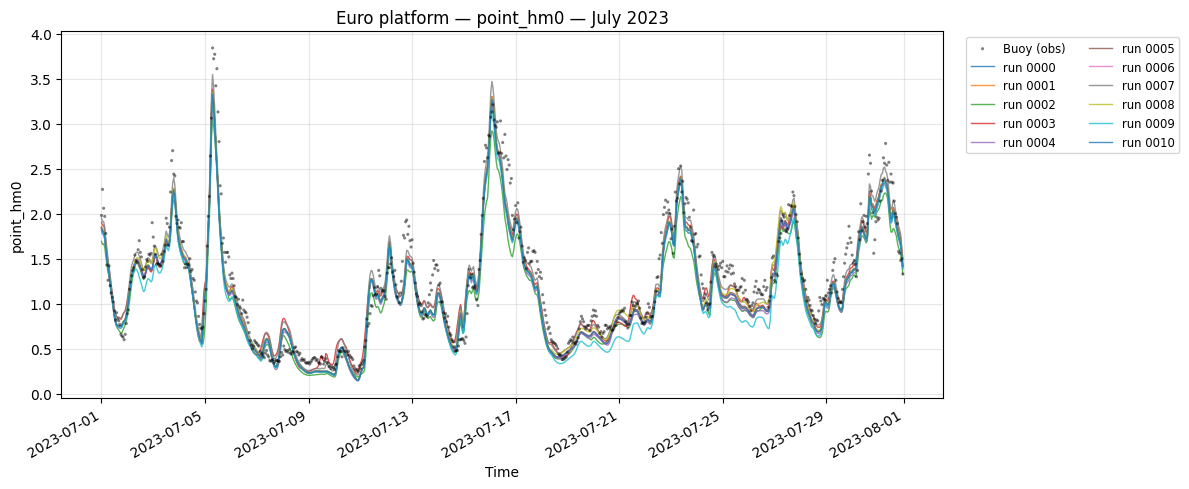

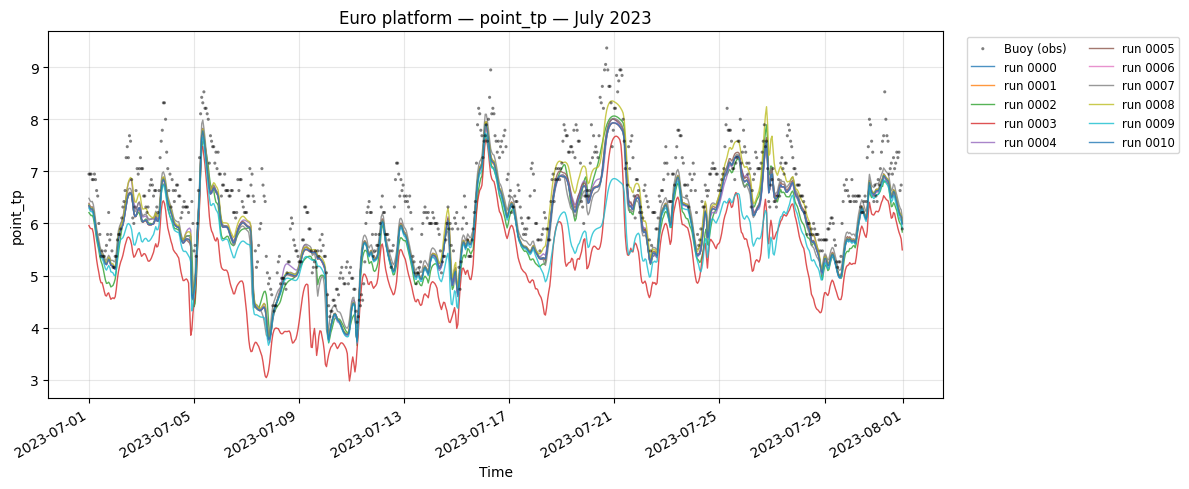

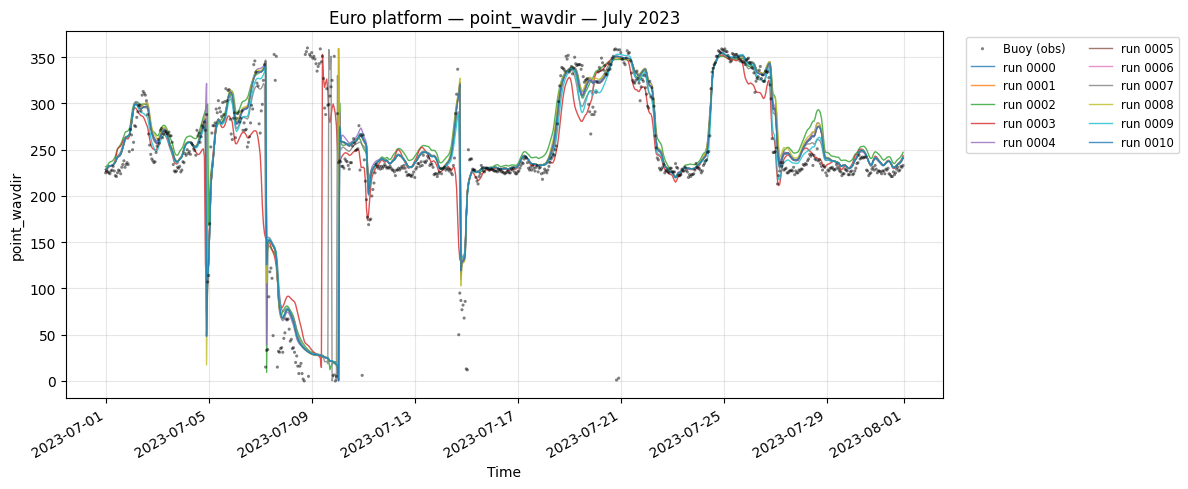

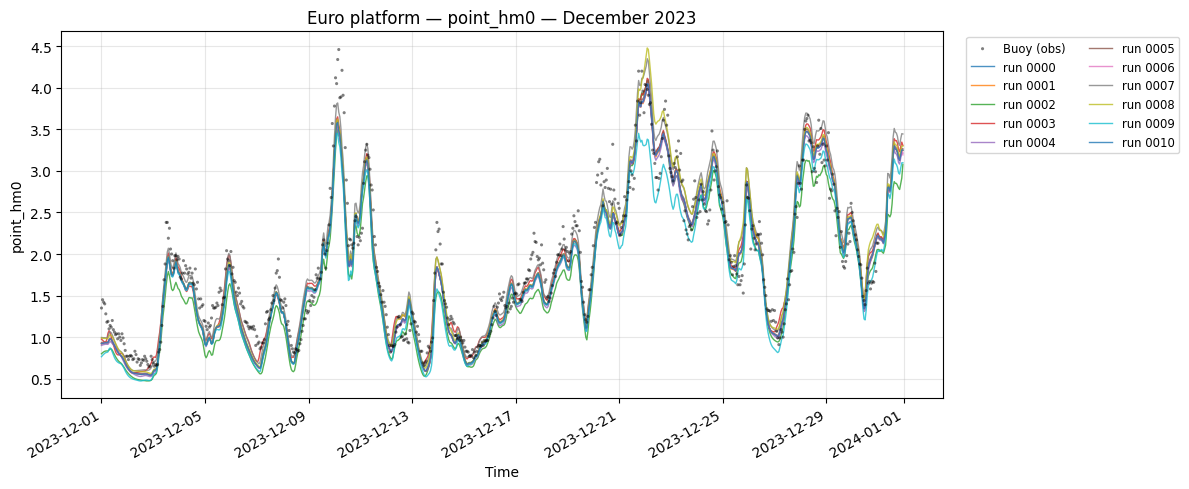

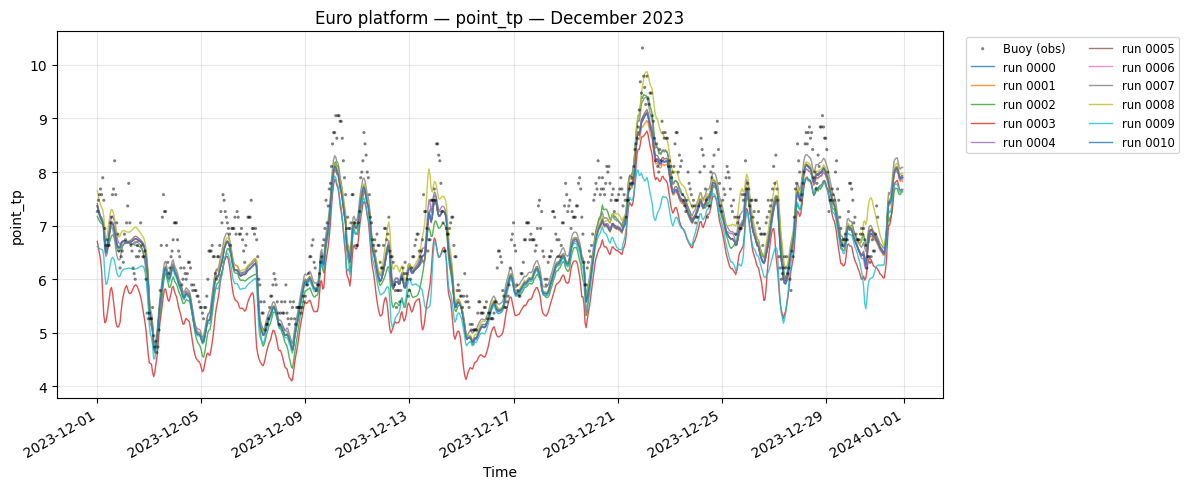

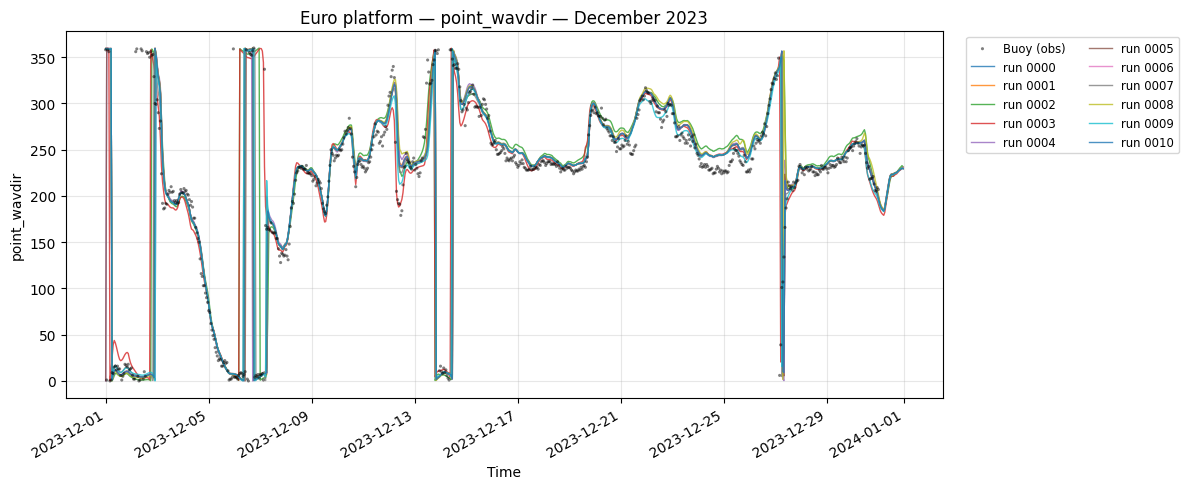

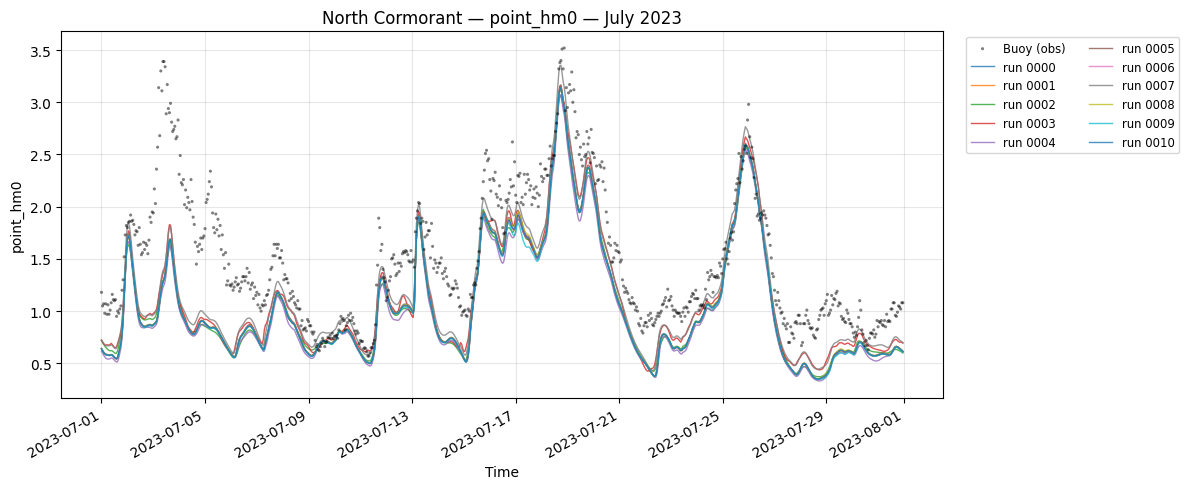

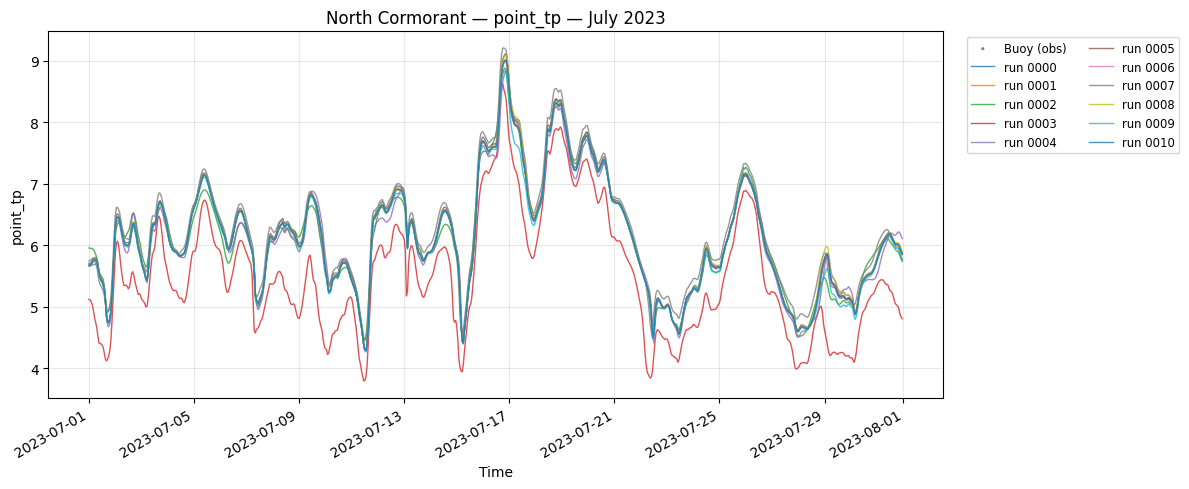

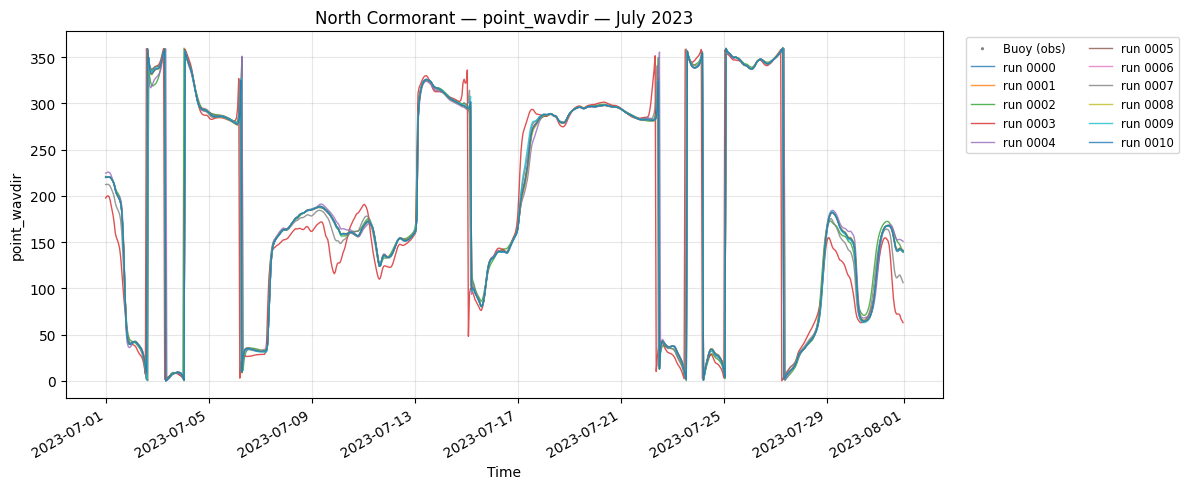

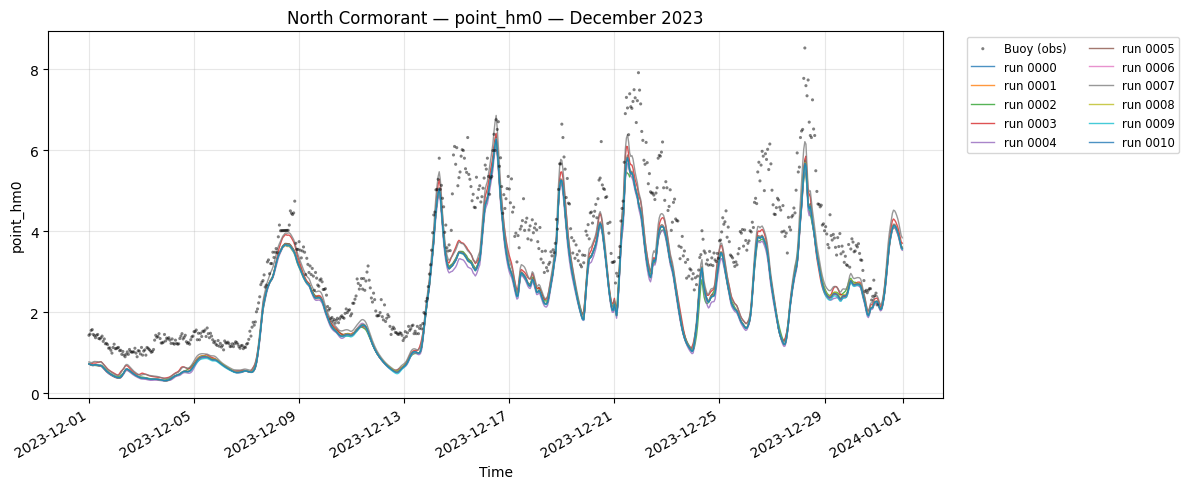

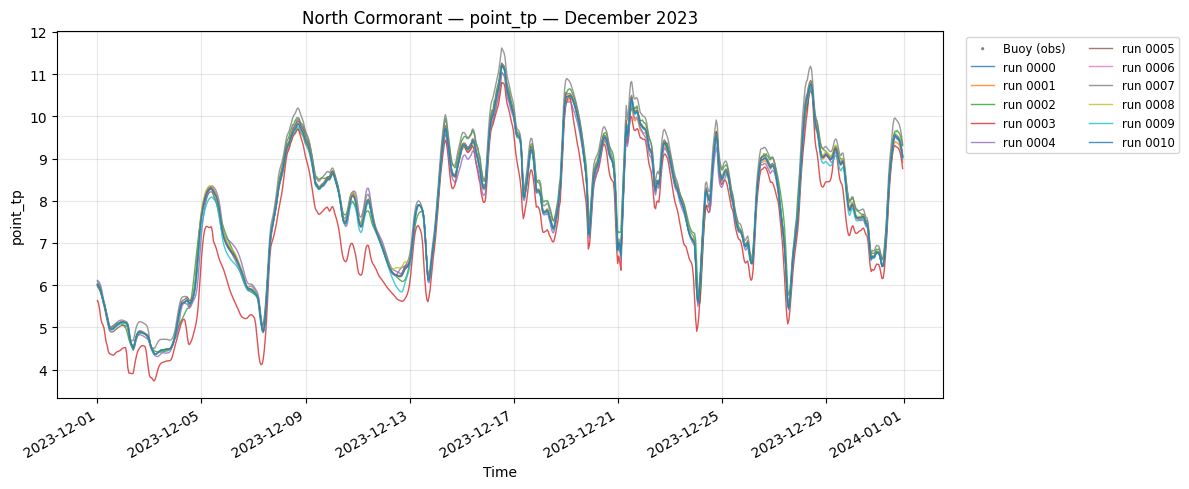

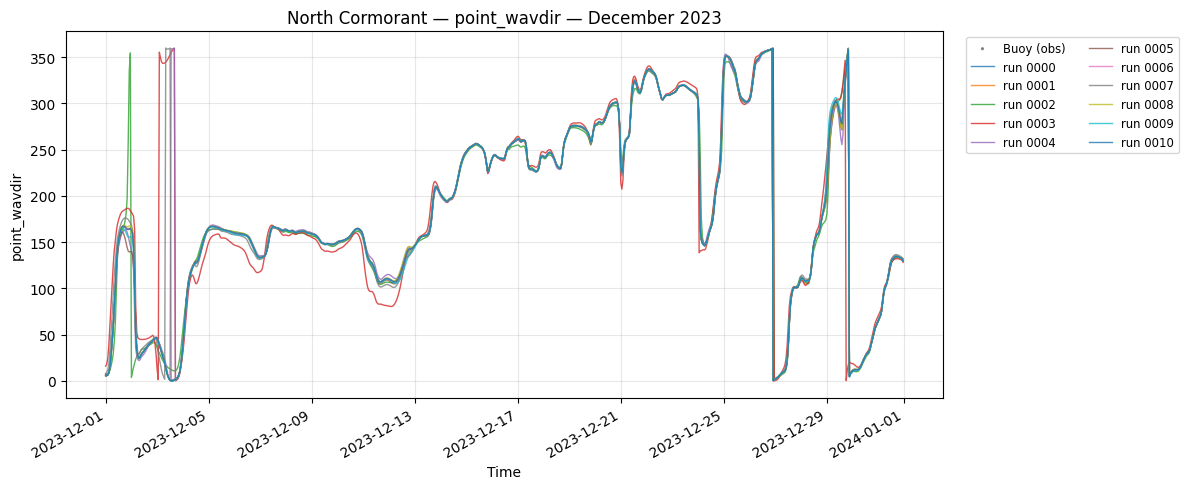

In [14]:
def plot_station_month(data_per_run_month, obs_data_per_station_month, 
                       station, month_label, j_min, j_max, year_start):
    """
    Plot model runs and observations for a given station and month.
    Plots point_hm0, point_tp, and point_wavdir if available.
    """
    variables = ['point_hm0', 'point_tp', 'point_wavdir']

    for model_var in variables:
        fig, ax = plt.subplots(figsize=(12, 5))
        candidate_runs = sorted(list(data_per_run_month.keys()))
        obs_df = obs_data_per_station_month.get(station)

        # Skip if variable not found in any run
        if not any(model_var in data_per_run_month[r].get(station, {}) for r in candidate_runs):
            print(f"⚠️ No '{model_var}' data found for {station} ({month_label}). Skipping.")
            plt.close(fig)
            continue

        obs_var = map_variable_measurements(model_var)

        # --- Plot Observations ---
        if obs_df is not None and obs_var in obs_df.columns:
            obs_t = pd.to_datetime(obs_df['time'])
            # Convert timezone if necessary
            if getattr(obs_t.dt, 'tz', None) is not None:
                obs_t = obs_t.dt.tz_convert('UTC').dt.tz_localize(None)
            obs_y = obs_df[obs_var].values

            mask_obs = (obs_t >= pd.Timestamp(j_min)) & (obs_t <= pd.Timestamp(j_max))
            ax.scatter(obs_t[mask_obs], obs_y[mask_obs], color='k', s=5, label='Buoy (obs)',
                       edgecolors='none', zorder=10, alpha=0.5)
        else:
            print(f"No observational column '{obs_var}' for {station} ({month_label}).")

        # --- Plot each model run ---
        for run in candidate_runs:
            st = data_per_run_month.get(run, {}).get(station)
            if not st or model_var not in st:
                continue

            t = np.asarray(st.get('time', []))
            y = np.asarray(st.get(model_var, []))
            if t.size == 0 or y.size == 0:
                continue

            # Convert to datetime64
            t = pd.to_datetime(t).values.astype('datetime64[ns]')
            mask = (t >= np.datetime64(j_min)) & (t <= np.datetime64(j_max))
            ax.plot(pd.to_datetime(t[mask]), y[mask], label=f"run {run}", linewidth=1, alpha=0.8)

        # --- Formatting ---
        ax.set_title(f"{station} — {model_var} — {month_label} {year_start}")
        ax.set_ylabel(model_var)
        ax.set_xlabel("Time")
        ax.grid(True, alpha=0.3)
        ax.legend(ncol=2, fontsize='small', loc='upper left', bbox_to_anchor=(1.02, 1))
        fig.autofmt_xdate()
        plt.tight_layout()
        plt.show()


# === EXAMPLE USAGE ===

# Loop over stations and months
stations = ["Euro platform", "North Cormorant"]
months = [
    ("July", data_per_run_july, obs_data_per_station_july, j_min, j_max),
    ("December", data_per_run_december, obs_data_per_station_december, d_min, d_max)
]

for stn in stations:
    for month_label, data_run, obs_data, tmin, tmax in months:
        plot_station_month(
            data_per_run_month=data_run,
            obs_data_per_station_month=obs_data,
            station=stn,
            month_label=month_label,
            j_min=tmin,
            j_max=tmax,
            year_start=year_start
        )

In [15]:
# Extract the time arrays
obs_time = pd.to_datetime(obs_data_per_station_july['Euro platform']['time'])
model_time = pd.to_datetime(data_per_run_july['0000']['Euro platform']['time'])

# Find the missing times
missing_times = model_time[~model_time.isin(obs_time)]

# Print the missing times
print("Missing times in observations:")
print(missing_times)


print(obs_data_per_station_july['Euro platform']['hm0'].shape)
print(data_per_run_july['0000']['Euro platform']['point_depth'].shape)

Missing times in observations:
DatetimeIndex([], dtype='datetime64[ns]', freq=None)
(744,)
(744,)


In [16]:
pinball_quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

def _filter_valid_pairs(obs, pred):
    """Return obs and pred as numeric arrays of equal length, with NaNs removed."""
    # Flatten and convert to float, replacing invalid values with NaN
    obs = np.ravel(obs)
    pred = np.ravel(pred)

    def to_float_array(x):
        arr = np.empty(len(x), dtype=float)
        for i, val in enumerate(x):
            try:
                arr[i] = float(val)
            except (ValueError, TypeError):
                arr[i] = np.nan
        return arr

    obs = to_float_array(obs)
    pred = to_float_array(pred)

    # Trim to same length (use the smallest available)
    n = min(len(obs), len(pred))
    if n == 0:
        return np.array([]), np.array([])
    obs = obs[:n]
    pred = pred[:n]

    # Remove NaNs
    mask = np.isfinite(obs) & np.isfinite(pred)
    if not np.any(mask):
        return np.array([]), np.array([])
    return obs[mask], pred[mask]

def rmse(obs, pred):
    obs, pred = _filter_valid_pairs(obs, pred)
    if obs.size == 0:
        return np.nan
    return np.sqrt(np.mean((pred - obs) ** 2))

def bias(obs, pred):
    obs, pred = _filter_valid_pairs(obs, pred)
    if obs.size == 0:
        return np.nan
    return np.mean(pred - obs)

def scatter_index(obs, pred):
    obs, pred = _filter_valid_pairs(obs, pred)
    if obs.size == 0:
        return np.nan
    return rmse(obs, pred) / np.mean(obs)

def pinball_loss_from_list(obs, pred, quantile_pinball_list):
    obs, pred = _filter_valid_pairs(obs, pred)
    if obs.size == 0:
        return [np.nan] * len(quantile_pinball_list)
    delta = obs - pred
    return [np.mean(np.maximum(q * delta, (q - 1) * delta)) for q in quantile_pinball_list]

def calculate_statistics(obs, pred, quantile_pinball):
    rmse_val = rmse(obs, pred)
    bias_val = bias(obs, pred)
    si_val = scatter_index(obs, pred)
    pinball_vals = pinball_loss_from_list(obs, pred, quantile_pinball)
    return rmse_val, bias_val, si_val, pinball_vals

# ===== Variable mapping (model ↔ measurements) =====
variable_mapping_measurements = {
    'point_hm0': 'hm0',
    'point_tp': 't13',
    # 'point_wavdir': 'th0',
}

def map_variable_measurements(variable):
    return variable_mapping_measurements.get(variable, variable)

def make_list_of_variables(variable_mapping):
    return list(variable_mapping.keys())

variable_list = make_list_of_variables(variable_mapping_measurements)

# ===== Simplified statistics computation =====
def compute_statistics_for_all(model_dict, obs_dict, variable_list, quantile_pinball):
    """
    Compute RMSE, Bias, Scatter Index, and Pinball Loss between model and observations.
    """
    df_stats = {}

    for run in model_dict:  # Each model run
        df_stats[run] = {}
        for station in model_dict[run]:
            df_stats[run][station] = {}

            for model_var in variable_list:
                if model_var not in model_dict[run][station]:
                    continue
                obs_var = map_variable_measurements(model_var)
                if obs_var not in obs_dict.get(station, {}):
                    continue

                obs = obs_dict[station][obs_var]
                pred = model_dict[run][station][model_var]

                rmse_val, bias_val, si_val, pinball_vals = calculate_statistics(
                    obs, pred, quantile_pinball
                )

                # Store results
                df_stats[run][station][model_var] = {
                    "RMSE": rmse_val,
                    "Bias": bias_val,
                    "Scatter Index": si_val,
                }
                for i, q in enumerate(quantile_pinball):
                    df_stats[run][station][model_var][f"Pinball Loss (q={q})"] = pinball_vals[i]

    return df_stats

# ===== Compute for July and December =====
df_statistics_july = compute_statistics_for_all(
    data_per_run_july,
    obs_data_per_station_july,
    variable_list,
    pinball_quantiles,
)

df_statistics_december = compute_statistics_for_all(
    data_per_run_december,
    obs_data_per_station_december,
    variable_list,
    pinball_quantiles,
)

In [17]:


print(df_statistics_july['0000']['North Cormorant']['point_hm0']['RMSE'])

0.548288890199068


In [18]:
def _filter_valid_angle_pairs(obs, pred, time):
    """Return obs, pred, time as numeric arrays with matching lengths and NaNs removed."""
    # Flatten all inputs
    obs = np.ravel(obs)
    pred = np.ravel(pred)
    time = np.ravel(time)

    # Convert safely to float
    def to_float_array(x):
        arr = np.empty(len(x), dtype=float)
        for i, val in enumerate(x):
            try:
                arr[i] = float(val)
            except (ValueError, TypeError):
                arr[i] = np.nan
        return arr

    obs = to_float_array(obs)
    pred = to_float_array(pred)

    # Match lengths
    n = min(len(obs), len(pred), len(time))
    if n == 0:
        return np.array([]), np.array([]), np.array([])
    obs, pred, time = obs[:n], pred[:n], time[:n]

    # Remove NaNs synchronously
    mask = np.isfinite(obs) & np.isfinite(pred)
    if not np.any(mask):
        return np.array([]), np.array([]), np.array([])
    return obs[mask], pred[mask], time[mask]


def angular_diffs(obs_angles, pred_angles):
    """Compute angular differences (in degrees) between observed and predicted angles."""
    obs_rad = np.deg2rad(obs_angles)
    pred_rad = np.deg2rad(pred_angles)
    diffs_rad = np.arctan2(np.sin(pred_rad - obs_rad), np.cos(pred_rad - obs_rad))
    return np.rad2deg(diffs_rad)


def angular_RMSE(obs_angles, pred_angles):
    """Angular RMSE (in degrees)."""
    diffs = angular_diffs(obs_angles, pred_angles)
    return np.sqrt(np.mean(diffs ** 2)) if diffs.size > 0 else np.nan


def create_df_directions_multiple_runs(model_dict, obs_dict, model_var="point_wavdir", obs_var="th0"):
    """
    Compute directional statistics for multiple runs.

    Parameters
    ----------
    model_dict : dict
        Nested dict like [run][station][variable].
    obs_dict : dict
        Nested dict like [station][variable].
    model_var : str
        Variable name for model wave direction.
    obs_var : str
        Variable name for observed wave direction.

    Returns
    -------
    df_directions : dict
        Nested dict [run][station] containing:
        - wavedir_obs
        - wavedir_model
        - wavedir_error
        - wavedir_error_mean
        - wavedir_error_std
        - wavedir_rmse
        - normalised versions (radians / 2π)
    """
    df_directions = {}

    for run in model_dict:
        df_directions[run] = {}

        for station in model_dict[run]:
            if model_var not in model_dict[run][station]:
                continue
            if obs_var not in obs_dict.get(station, {}):
                continue

            # Retrieve data
            obs_angles = obs_dict[station][obs_var]
            pred_angles = model_dict[run][station][model_var]
            time = model_dict[run][station].get("time", np.arange(len(pred_angles)))

            # Filter valid numeric pairs
            obs_angles, pred_angles, time = _filter_valid_angle_pairs(obs_angles, pred_angles, time)

            # Skip if no data
            if obs_angles.size == 0:
                continue

            # Compute angular stats
            diffs = angular_diffs(obs_angles, pred_angles)
            mean_err = np.mean(diffs)
            std_err = np.std(diffs)
            rmse_val = angular_RMSE(obs_angles, pred_angles)
            norm_err = np.deg2rad(diffs) / (2 * np.pi)

            df_directions[run][station] = {
                "time": time,
                "wavedir_obs": obs_angles,
                "wavedir_model": pred_angles,
                "wavedir_error": diffs,
                "wave_dir_error_normalised": norm_err,
                "wavedir_error_mean": mean_err,
                "wavedir_error_std": std_err,
                "wave_dir_error_normalised_mean": np.mean(norm_err),
                "wave_dir_error_normalised_std": np.std(norm_err),
                "wavedir_rmse": rmse_val,
                "wave_dir_rmse_normalised": np.deg2rad(rmse_val) / (2 * np.pi),
            }

    return df_directions

df_directions_july = create_df_directions_multiple_runs(
    data_per_run_july,
    obs_data_per_station_july,
    model_var="point_wavdir",
    obs_var="th0",
)

df_directions_december = create_df_directions_multiple_runs(
    data_per_run_december,
    obs_data_per_station_december,
    model_var="point_wavdir",
    obs_var="th0",
)

In [19]:
# Iterate over all runs and print RMSE, Bias, and SI for "Euro platform" and "hm0"

print("--------------STATS JULY------------------")
print("Euro platform Hm0 stats:")
for run in df_statistics_july:
    if "Euro platform" in df_statistics_july[run]:
        stats = df_statistics_july[run]["Euro platform"].get("point_hm0", {})
        rmse = stats.get("RMSE", "N/A")
        bias = stats.get("Bias", "N/A")
        si = stats.get("Scatter Index", "N/A")
        print(f"Run: {run}, RMSE: {rmse}, Bias: {bias}, SI: {si}")

print("Euro platform Tp stats:")
# Iterate over all runs and print RMSE, Bias, and SI for "Euro platform"
for run in df_statistics_july:
    if "Euro platform" in df_statistics_july[run]:
        stats = df_statistics_july[run]["Euro platform"].get("point_tp", {})
        rmse = stats.get("RMSE", "N/A")
        bias = stats.get("Bias", "N/A")
        si = stats.get("Scatter Index", "N/A")
        print(f"Run: {run}, RMSE: {rmse}, Bias: {bias}, SI: {si}")

print("Euro platform Direction stats:")

# Print the direction RMSE for July at "Euro platform" for all runs
for run in df_directions_july:
    if "Euro platform" in df_directions_july[run]:
        direction_rmse = df_directions_july[run]["Euro platform"].get("wavedir_rmse", "N/A")
        print(f"Run: {run}, Direction RMSE for July at Euro platform: {direction_rmse}")

print("North Cormorant Hm0 stats:")
# Iterate over all runs and print RMSE, Bias, and SI for "North Cormorant" and "hm0"
for run in df_statistics_july:
    if "North Cormorant" in df_statistics_july[run]:
        stats = df_statistics_july[run]["North Cormorant"].get("point_hm0", {})
        rmse = stats.get("RMSE", "N/A")
        bias = stats.get("Bias", "N/A")
        si = stats.get("Scatter Index", "N/A")
        print(f"Run: {run}, RMSE: {rmse}, Bias: {bias}, SI: {si}")

print("North Cormorant Tp stats:")
# Iterate over all runs and print RMSE, Bias, and SI for "North Cormorant" and "tp"
for run in df_statistics_july:
    if "North Cormorant" in df_statistics_july[run]:
        stats = df_statistics_july[run]["North Cormorant"].get("point_tp", {})
        rmse = stats.get("RMSE", "N/A")
        bias = stats.get("Bias", "N/A")
        si = stats.get("Scatter Index", "N/A")
        print(f"Run: {run}, RMSE: {rmse}, Bias: {bias}, SI: {si}")

print("North Cormorant Direction stats:")
# Print the direction RMSE for July at "North Cormorant" for all runs
for run in df_directions_july:
    if "North Cormorant" in df_directions_july[run]:
        direction_rmse = df_directions_july[run]["North Cormorant"].get("wavedir_rmse", "N/A")
        print(f"Run: {run}, Direction RMSE for July at North Cormorant: {direction_rmse}")


--------------STATS JULY------------------
Euro platform Hm0 stats:
Run: 0000, RMSE: 0.2122671595310054, Bias: -0.11240988999925634, SI: 0.1694293234608233
Run: 0001, RMSE: 0.21389431145259352, Bias: -0.1162701098717028, SI: 0.17072809831535932
Run: 0002, RMSE: 0.2635274364718382, Bias: -0.18067935812216934, SI: 0.2103447154681825
Run: 0003, RMSE: 0.19932870917042383, Bias: -0.060289576430154104, SI: 0.1591019939951243
Run: 0004, RMSE: 0.22765317844745786, Bias: -0.13697897302447468, SI: 0.18171027535903342
Run: 0005, RMSE: 0.2083109826116175, Bias: -0.10599593832287738, SI: 0.16627154634436217
Run: 0006, RMSE: 0.21228538157681054, Bias: -0.1124146173525882, SI: 0.16944386809834358
Run: 0007, RMSE: 0.18139443519053203, Bias: -0.0268983530509536, SI: 0.1447870527960818
Run: 0008, RMSE: 0.2039452728747216, Bias: -0.0879316699288545, SI: 0.16278688461532745
Run: 0009, RMSE: 0.25183237244159473, Bias: -0.16867973611479806, SI: 0.20100984336242125
Run: 0010, RMSE: 0.2122396591123353, Bias: 

In [20]:
# Iterate over all runs and print RMSE, Bias, and SI for "Euro platform" and "hm0"

print("--------------STATS DECEMBER------------------")
print("Euro platform Hm0 stats:")
for run in df_statistics_december:
    if "Euro platform" in df_statistics_december[run]:
        stats = df_statistics_december[run]["Euro platform"].get("point_hm0", {})
        rmse = stats.get("RMSE", "N/A")
        bias = stats.get("Bias", "N/A")
        si = stats.get("Scatter Index", "N/A")
        print(f"Run: {run}, RMSE: {rmse}, Bias: {bias}, SI: {si}")

print("Euro platform Tp stats:")
# Iterate over all runs and print RMSE, Bias, and SI for "Euro platform"
for run in df_statistics_december:
    if "Euro platform" in df_statistics_december[run]:
        stats = df_statistics_december[run]["Euro platform"].get("point_tp", {})
        rmse = stats.get("RMSE", "N/A")
        bias = stats.get("Bias", "N/A")
        si = stats.get("Scatter Index", "N/A")
        print(f"Run: {run}, RMSE: {rmse}, Bias: {bias}, SI: {si}")

print("Euro platform Direction stats:")

# Print the direction RMSE for December at "Euro platform" for all runs
for run in df_directions_december:
    if "Euro platform" in df_directions_december[run]:
        direction_rmse = df_directions_december[run]["Euro platform"].get("wavedir_rmse", "N/A")
        print(f"Run: {run}, Direction RMSE for December at Euro platform: {direction_rmse}")

print("North Cormorant Hm0 stats:")
# Iterate over all runs and print RMSE, Bias, and SI for "North Cormorant" and "hm0"
for run in df_statistics_december:
    if "North Cormorant" in df_statistics_december[run]:

        stats = df_statistics_december[run]["North Cormorant"].get("point_hm0", {})
        rmse = stats.get("RMSE", "N/A")
        bias = stats.get("Bias", "N/A")
        si = stats.get("Scatter Index", "N/A")
        print(f"Run: {run}, RMSE: {rmse}, Bias: {bias}, SI: {si}")

print("North Cormorant Tp stats:")
# Iterate over all runs and print RMSE, Bias, and SI for "North Cormorant" and "tp"
for run in df_statistics_december:
    if "North Cormorant" in df_statistics_december[run]:
        stats = df_statistics_december[run]["North Cormorant"].get("point_tp", {})
        rmse = stats.get("RMSE", "N/A")
        bias = stats.get("Bias", "N/A")
        si = stats.get("Scatter Index", "N/A")
        print(f"Run: {run}, RMSE: {rmse}, Bias: {bias}, SI: {si}")

print("North Cormorant Direction stats:")
# Print the direction RMSE for December at "North Cormorant" for all runs
for run in df_directions_december:
    if "North Cormorant" in df_directions_december[run]:
        direction_rmse = df_directions_december[run]["North Cormorant"].get("wavedir_rmse", "N/A")
        print(f"Run: {run}, Direction RMSE for December at North Cormorant: {direction_rmse}")

--------------STATS DECEMBER------------------
Euro platform Hm0 stats:
Run: 0000, RMSE: 0.2515650209956129, Bias: -0.09562157893809131, SI: 0.13311295410786583
Run: 0001, RMSE: 0.253103691193272, Bias: -0.1005729189229904, SI: 0.13392712507089374
Run: 0002, RMSE: 0.3136568286137861, Bias: -0.21163932968277208, SI: 0.1659681734274725
Run: 0003, RMSE: 0.24328870678139497, Bias: -0.04578360319468249, SI: 0.12873363050469017
Run: 0004, RMSE: 0.25928137317368016, Bias: -0.12066064292944749, SI: 0.13719597975783132
Run: 0005, RMSE: 0.25043664093362855, Bias: -0.08762985769158095, SI: 0.13251588380447984
Run: 0006, RMSE: 0.25171780059718624, Bias: -0.09548428505369758, SI: 0.13319379580840257
Run: 0007, RMSE: 0.24527746963666908, Bias: 0.01667458451901992, SI: 0.12978596320833002
Run: 0008, RMSE: 0.26154817934712016, Bias: -0.04198382552552981, SI: 0.13839543612478708
Run: 0009, RMSE: 0.3101382503025823, Bias: -0.19731046041900008, SI: 0.16410635515317287
Run: 0010, RMSE: 0.2515223960163296,